In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
weatherData = pd.read_csv('./data/weatherHistory.csv')
weatherData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
Formatted Date              96453 non-null object
Summary                     96453 non-null object
Precip Type                 95936 non-null object
Temperature (C)             96453 non-null float64
Apparent Temperature (C)    96453 non-null float64
Humidity                    96453 non-null float64
Wind Speed (km/h)           96453 non-null float64
Wind Bearing (degrees)      96453 non-null int64
Visibility (km)             96453 non-null float64
Loud Cover                  96453 non-null int64
Pressure (millibars)        96453 non-null float64
Daily Summary               96453 non-null object
dtypes: float64(6), int64(2), object(4)
memory usage: 8.8+ MB


In [4]:
numerik_kolonlar = ['Humidity','Wind Speed (km/h)','Wind Bearing (degrees)','Pressure (millibars)']

In [6]:
Y = weatherData['Temperature (C)']
X = weatherData[numerik_kolonlar]

In [7]:
lrm = linear_model.LinearRegression()
lrm.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [8]:
print('Değişkenler: \n', lrm.coef_)
print('Sabit değer (bias): \n', lrm.intercept_)

Değişkenler: 
 [-3.24962454e+01 -2.01413742e-01  4.04836936e-03 -6.91759209e-04]
Sabit değer (bias): 
 37.926438185196574


Modelin ortalama hatası : 0.000000000000002


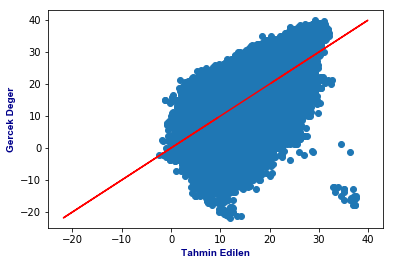

In [17]:
#Hata terimi ortalamada sıfır olmalıdır

tahmin = lrm.predict(X)
hatalar = Y - tahmin

baslik_font = {'family': 'arial','color':  'darkred','weight': 'bold','size': 15 }
eksen_font = {'family': 'arial','color':  'darkblue','weight': 'bold','size': 10 }

plt.scatter(tahmin, Y)
plt.xlabel('Tahmin Edilen', fontdict=eksen_font)
plt.ylabel('Gercek Deger', fontdict=eksen_font)
plt.plot(Y, Y, color="red")

print("Modelin ortalama hatası : {:.15f}".format(np.mean(hatalar)))


#Modelde sabit terimi eklediğimizden, modelin hatalarının ortalaması sıfırdır.

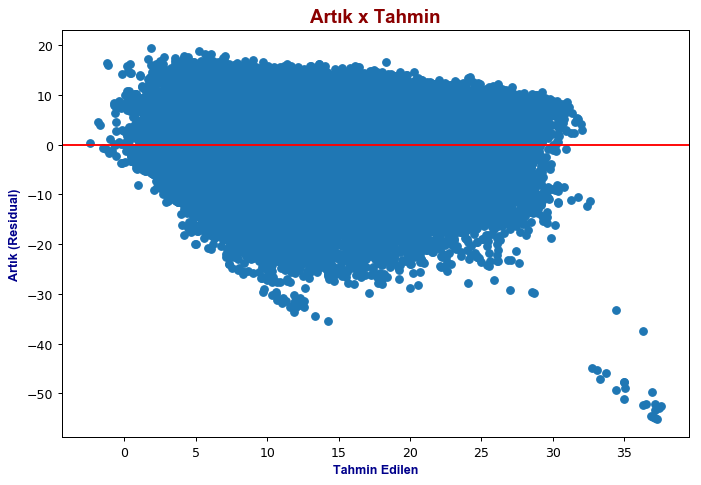

In [18]:
#homoscedasticity : hata varyansı, gözlemler arasında sistematik olarak değişmemelidir

plt.figure(figsize=(9,6), dpi=90)
plt.scatter(tahmin, hatalar)
plt.xlabel('Tahmin Edilen', fontdict=eksen_font)
plt.ylabel('Artık (Residual)', fontdict=eksen_font)
plt.axhline(y=0,color="red")
plt.title('Artık x Tahmin', fontdict=baslik_font)
plt.show()

In [15]:
#homoscedasticity testleri : Bartlett ve Levene testleridir.
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(tahmin, hatalar)
lev_stats = levene(tahmin, hatalar)

print("Bartlett test değeri : {0:3g} ve p değeri : {1:.21f}".format(bart_stats[0], bart_stats[1]))
print("Levene test değeri   : {0:3g} ve p değeri : {1:.21f}".format(lev_stats[0], lev_stats[1]))

#Her iki testin p değerleri 0.05'ten düşüktür. Dolayısıyla, test sonuçları null hipotezini reddeder
#Model heteroscedasticity sorunu mevcuttur
#Heteroscedasticityden muzdarip olmasına rağmen, tahmini katsayıların hala geçerlidir.

Bartlett test değeri : 2464.84 ve p değeri : 0.000000000000000000000
Levene test değeri   : 2321.24 ve p değeri : 0.000000000000000000000


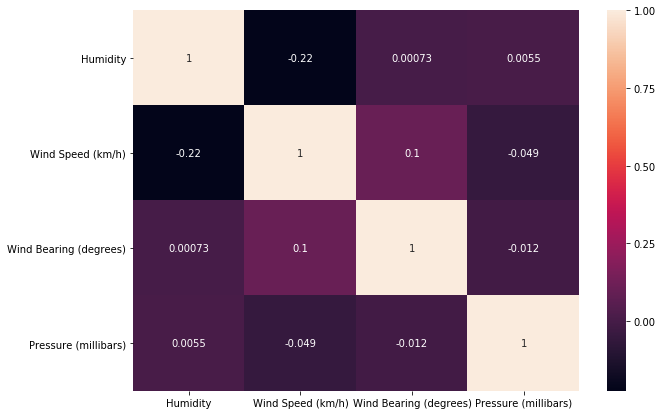

In [19]:
#düşük çoklu doğrusallık/low multicollinearity
#Genel olarak model özellikler bir biriyle ilişkisiz duruyor.
plt.figure(figsize=(10,7))
sns.heatmap(weatherData[numerik_kolonlar].corr(), annot = True)
plt.show()


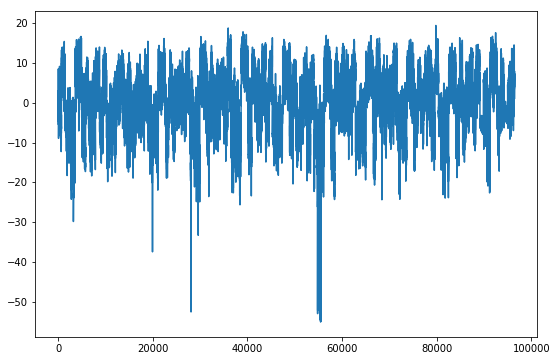

In [20]:
#hata terimleri birbiriyle ilişkisiz olmalıdır.

plt.figure(figsize=(9,6))
plt.plot(hatalar)
plt.show()

#ancak hata terimleri ilişkili duruyor. Bu durumda modelden doğrudan tahmin üretmek mümkün değil.

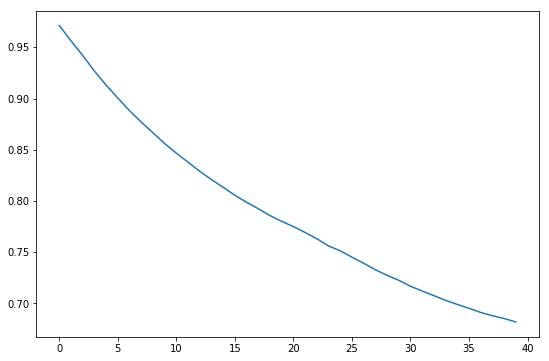

In [21]:
#Hatalar arasındaki otokorrelasyon da gözüküyor. 
from statsmodels.tsa.stattools import acf

acf_data = acf(hatalar)

plt.figure(figsize=(9,6))
plt.plot(acf_data[1:])
plt.show()

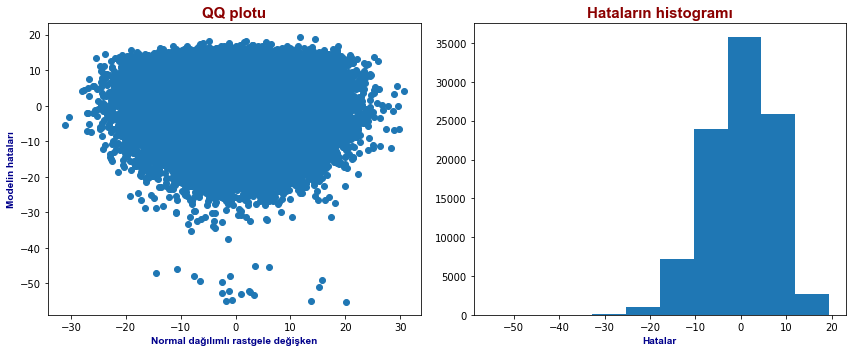

In [22]:
#Hataların normalliği (OLS için önemli değil)
#Hata koşullarının normalliğini kontrol etmek için çeşitli yollar vardır. Bunu yapmanın gayri resmi bir yolu, QQ çizimindeki hataları görselleştirmek veya histograma bakmaktır:
rand_nums = np.random.normal(np.mean(hatalar), np.std(hatalar), len(hatalar))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(rand_nums, hatalar)
plt.xlabel("Normal dağılımlı rastgele değişken", fontdict=eksen_font)
plt.ylabel("Modelin hataları", fontdict=eksen_font)
plt.title("QQ plotu", fontdict=baslik_font)

plt.subplot(1,2,2)
plt.hist(hatalar)
plt.xlabel("Hatalar", fontdict=eksen_font)
plt.title("Hataların histogramı", fontdict=baslik_font)

plt.tight_layout()
plt.show()

In [24]:
#Görselleştirmeler bize normallik hakkında ilk izlenimi verirken, bu konuda öğrenmenin en iyi yolu resmi istatistiksel 
#testler uygulamaktır. Bu amaçla tane scipy'nin stats modülünden Jarque Bera testi ve normal test adında 2 tane test 
#kullanıyoruz. Her iki testin null hipotezi, hataların normal olarak dağıldığını belirtir.
from scipy.stats import jarque_bera
from scipy.stats import normaltest
jb_stats = jarque_bera(hatalar)
norm_stats = normaltest(hatalar)

print("Jarque-Bera test değeri : {0} ve p değeri : {1}".format(jb_stats[0], jb_stats[1]))
print("Normal test değeri      : {0}  ve p değeri : {1:.30f}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test değeri : 3793.2967353856425 ve p değeri : 0.0
Normal test değeri      : 3375.4323077952217  ve p değeri : 0.000000000000000000000000000000


In [25]:
ev_fiyatlari = pd.read_csv('./data/ev_fiyatlari.csv')
ev_fiyatlari.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [26]:
SaleCond=pd.get_dummies(ev_fiyatlari.SaleCondition,prefix='SaleCond', drop_first=True)
SaleTyp=pd.get_dummies(ev_fiyatlari.SaleType,prefix='SaleTyp', drop_first=True)
KitchenQ=pd.get_dummies(ev_fiyatlari.KitchenQual,prefix='KitchenQ', drop_first=True)

In [27]:
numerik_kolonlar = [kolon for kolon in ev_fiyatlari.dtypes[ev_fiyatlari.dtypes.values == 'int64'].index 
                    if kolon not in ["Id", "SalePrice"] ]

In [28]:
X = ev_fiyatlari[numerik_kolonlar]
X=pd.concat([X,KitchenQ,SaleTyp,SaleCond], axis=1)
X.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleTyp_ConLI,SaleTyp_ConLw,SaleTyp_New,SaleTyp_Oth,SaleTyp_WD,SaleCond_AdjLand,SaleCond_Alloca,SaleCond_Family,SaleCond_Normal,SaleCond_Partial
0,60,8450,7,5,2003,2003,706,0,150,856,...,0,0,0,0,1,0,0,0,1,0
1,20,9600,6,8,1976,1976,978,0,284,1262,...,0,0,0,0,1,0,0,0,1,0
2,60,11250,7,5,2001,2002,486,0,434,920,...,0,0,0,0,1,0,0,0,1,0
3,70,9550,7,5,1915,1970,216,0,540,756,...,0,0,0,0,1,0,0,0,0,0
4,60,14260,8,5,2000,2000,655,0,490,1145,...,0,0,0,0,1,0,0,0,1,0


In [29]:
Y=ev_fiyatlari.SalePrice

In [30]:
#LinearRegression modeli 
lrm = linear_model.LinearRegression()
lrm.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Modelin ortalama hatası : -0.000000000163699


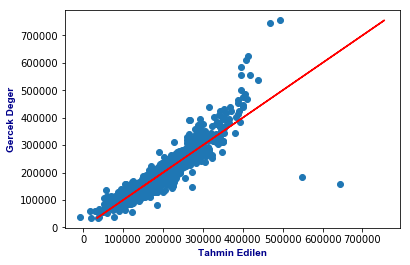

In [31]:

tahmin = lrm.predict(X)
hatalar = Y - tahmin

baslik_font = {'family': 'arial','color':  'darkred','weight': 'bold','size': 15 }
eksen_font = {'family': 'arial','color':  'darkblue','weight': 'bold','size': 10 }

plt.scatter(tahmin, Y)
plt.xlabel('Tahmin Edilen', fontdict=eksen_font)
plt.ylabel('Gercek Deger', fontdict=eksen_font)
plt.plot(Y, Y, color="red")

print("Modelin ortalama hatası : {:.15f}".format(np.mean(hatalar)))


#Modelde sabit terimi eklediğimizden, modelin hatalarının ortalaması sıfırdır.

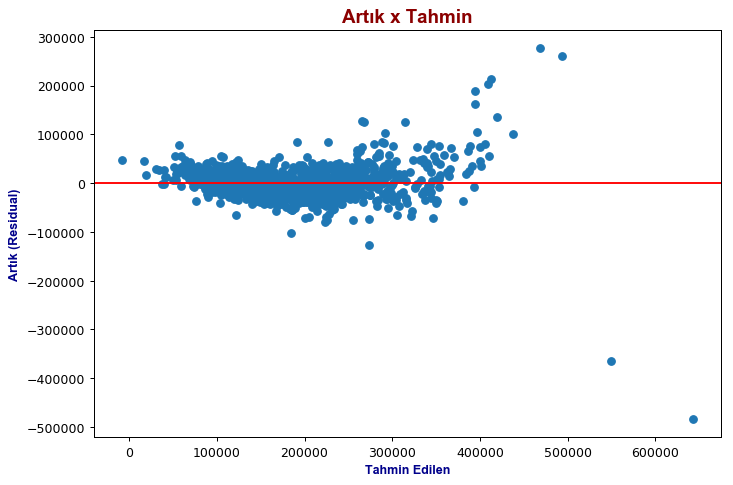

In [32]:
#homoscedasticity : hata varyansı, gözlemler arasında sistematik olarak değişmemelidir

plt.figure(figsize=(9,6), dpi=90)
plt.scatter(tahmin, hatalar)
plt.xlabel('Tahmin Edilen', fontdict=eksen_font)
plt.ylabel('Artık (Residual)', fontdict=eksen_font)
plt.axhline(y=0,color="red")
plt.title('Artık x Tahmin', fontdict=baslik_font)
plt.show()

In [33]:
#homoscedasticity testleri : Bartlett ve Levene testleridir.
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(tahmin, hatalar)
lev_stats = levene(tahmin, hatalar)

print("Bartlett test değeri : {0:3g} ve p değeri : {1:.21f}".format(bart_stats[0], bart_stats[1]))
print("Levene test değeri   : {0:3g} ve p değeri : {1:.21f}".format(lev_stats[0], lev_stats[1]))


Bartlett test değeri : 851.05 ve p değeri : 0.000000000000000000000
Levene test değeri   : 692.764 ve p değeri : 0.000000000000000000000


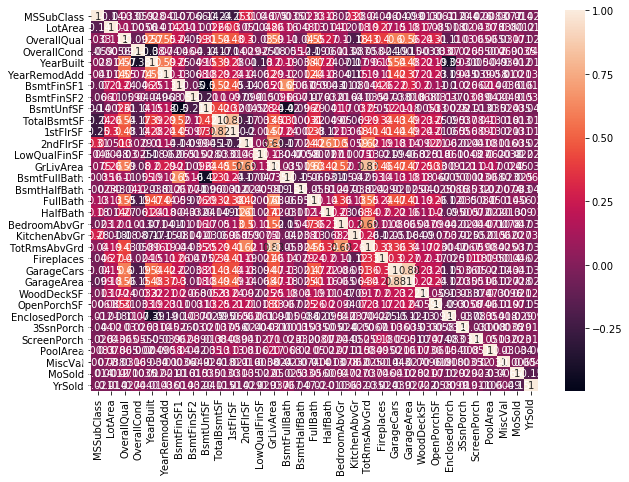

In [34]:
#düşük çoklu doğrusallık/low multicollinearity
#Modelde bazı özellikler correle duruyor. Ancak bu modelden tahmin üretmemize engel değil.
#Sadece modelin açıklayıcılığı kayboluyor.
plt.figure(figsize=(10,7))
sns.heatmap(ev_fiyatlari[numerik_kolonlar].corr(), annot = True)
plt.show()

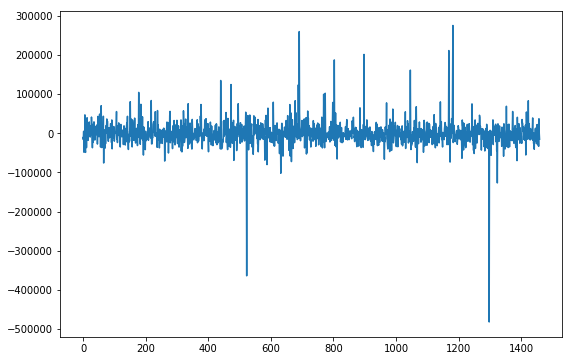

In [35]:
#hata terimleri birbiriyle ilişkisiz olmalıdır.

plt.figure(figsize=(9,6))
plt.plot(hatalar)
plt.show()

#Hata terimleri ilişkisiz duruyor.

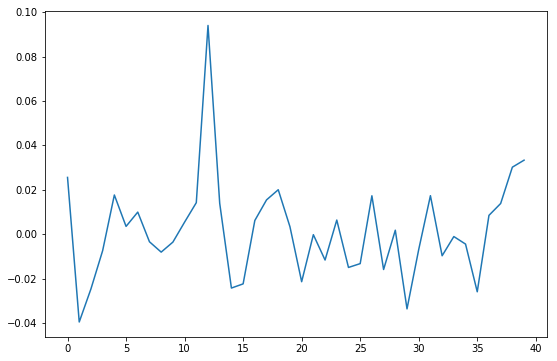

In [36]:
#Hatalar arasındaki otokorrelasyon  gözükmüyor. 
from statsmodels.tsa.stattools import acf

acf_data = acf(hatalar)

plt.figure(figsize=(9,6))
plt.plot(acf_data[1:])
plt.show()

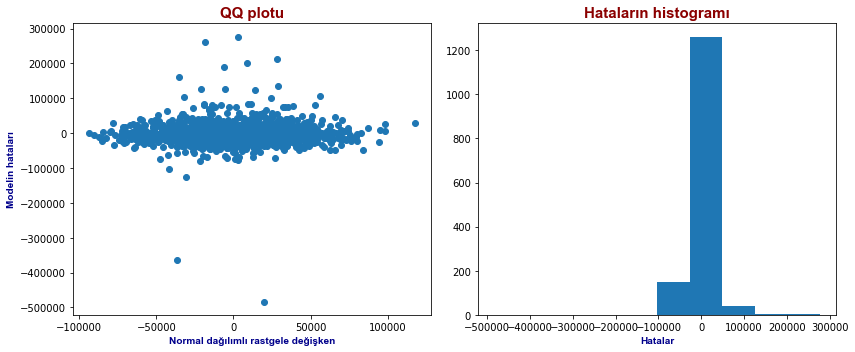

In [37]:
#Hataların normalliği (OLS için önemli değil)
#Hata koşullarının normalliğini kontrol etmek için çeşitli yollar vardır. 
#Bunu yapmanın gayri resmi bir yolu, QQ çizimindeki hataları görselleştirmek veya histograma bakmaktır:
rand_nums = np.random.normal(np.mean(hatalar), np.std(hatalar), len(hatalar))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(rand_nums, hatalar)
plt.xlabel("Normal dağılımlı rastgele değişken", fontdict=eksen_font)
plt.ylabel("Modelin hataları", fontdict=eksen_font)
plt.title("QQ plotu", fontdict=baslik_font)

plt.subplot(1,2,2)
plt.hist(hatalar)
plt.xlabel("Hatalar", fontdict=eksen_font)
plt.title("Hataların histogramı", fontdict=baslik_font)

plt.tight_layout()
plt.show()